# Demo

In this course you can learn the basics of image processing with Python and scikit-image. In particular you can learn about:
- strict basics of Python to get through the course
- Numpy, the library that allows to easily handle large arrays of numbers like images
- image processing with scikit-image, in particular filtering, thresholding, morphological operations, and particle analysis.

The present notebook demonstrates the sort of complete workflow that one can create with such tools. So that people already using Fiji macros have a reference point, this example follows the workflow demonstrated in the [NEUBIAS Academy course on Fiji Macro Programming](https://github.com/ahklemm/ImageJMacro_Introduction) given by Anna Klemm.  The example uses images from the [Cell Atlas](https://www.proteinatlas.org/humanproteome/cell) of the Human Protein Atlas (HPA) project where a large collection of proteins have been tagged and imaged to determine their cellular location. Specifically, we downloaded a series of [images](images) from the Atlas, with some cells showing nucleoplasm localization and some nuclear membrane localization. The idea of the workflow is to compare the signal within the nucleus with that on its edge to determine for each image whether the protein is membrane bound or not.

For more information  on the dataset, see the publication of Thul PJ et al., A subcellular map of the human proteome. **Science**. (2017) DOI: [10.1126/science.aal3321](https://doi.org/10.1126/science.aal3321). All images are covered by a [Creative Commons Attribution-ShareAlike 3.0 International License](https://creativecommons.org/licenses/by-sa/3.0/).

## Complete workflow

We first demonstrate here the complete workflow and break it down in parts in the following sections. First we import packages, load to images and display them to have a feeling of the content:

In [1]:
import skimage
import skimage.io
import numpy as np
import matplotlib.pyplot as plt
import skimage.filters
from pathlib import Path
import scipy.ndimage as ndi
import pandas as pd

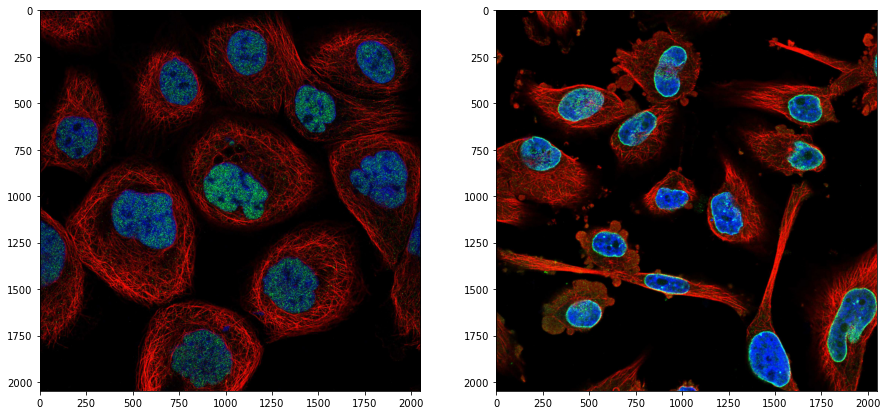

In [2]:
fig, ax = plt.subplots(1,2,figsize=(15,15))
ax[0].imshow(skimage.io.imread('https://github.com/guiwitz/PyImageCourse_beginner/raw/cellatlas/images/24138_196_F7_2.tif'))
ax[1].imshow(skimage.io.imread('https://github.com/guiwitz/PyImageCourse_beginner/raw/cellatlas/images/27897_273_C8_2.tif'));

Then we run the analysis on the full dataset:

In [3]:
channel_nuclei = 2
channe_signal = 1

ratios = []

for f in Path('images/').glob('*.tif'):
    # import image
    image = skimage.io.imread(f)
    
    # filter the nuclei image
    im_filtered = skimage.filters.median(image[:,:,channel_nuclei], skimage.morphology.disk(5))
    
    # threshold
    th = skimage.filters.threshold_otsu(im_filtered)
    nucl_th = im_filtered > th
    
    # clean-up
    nucl_close = skimage.morphology.binary_closing(nucl_th, selem=skimage.morphology.disk(5))
    nucl_fill = ndi.binary_fill_holes(nucl_close, skimage.morphology.disk(5))
    
    # create band around nuclei
    eroded = skimage.morphology.binary_erosion(nucl_fill, selem=skimage.morphology.disk(10))
    edge = np.logical_and(nucl_fill, np.logical_not(eroded))
    
    # label and measure
    im_lab = skimage.morphology.label(nucl_fill)
    measure_eroded = skimage.measure.regionprops_table(im_lab * eroded, image[:,:,channe_signal],
                                                       properties=('label', 'mean_intensity', 'area'))
    measure_edge = skimage.measure.regionprops_table(im_lab * edge, image[:,:,channe_signal],
                                                     properties=('label', 'mean_intensity', 'area'))
    
    # calculate ratios and filter by size.
    edge_dict = {}
    for i in range(len(measure_edge['label'])):
        if measure_edge['area'][i] > 100:
            edge_dict[measure_edge['label'][i]] = measure_edge['mean_intensity'][i]
    image_ratio = []
    for i in range(len(measure_eroded['label'])):
        temp_ratio = measure_eroded['mean_intensity'][i] / edge_dict[measure_eroded['label'][i]]
        image_ratio.append(temp_ratio)
    ratios.append(np.mean(image_ratio))
    
    '''
    ## More elegant solution with Pandas df
    # turn results into dataframes
    measure_eroded_df = pd.DataFrame(measure_eroded)
    measure_edge_df = pd.DataFrame(measure_edge)
    
    # combined nuclei and band measures and compute intensity ratio mean
    merged = pd.merge(measure_eroded_df, measure_edge_df, on='label', how='inner')
    merged['ratio'] = merged['mean_intensity_x']/merged['mean_intensity_y']
    
    # add to final list
    ratios.append(merged.mean()['ratio'])
    '''
ratios = np.array(ratios)

# get name of all files
all_files = np.array([a.name for a in Path('images/').glob('*.tif')])

# select high- and low-ratio images
high_ratio = all_files[np.array(ratios)>1]
low_ratio = all_files[np.array(ratios)<1]

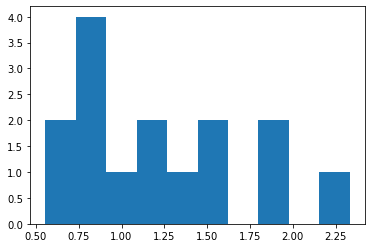

In [4]:
plt.hist(ratios);

In the end we obtain a list of ratios for each image and we can set a threshold on what qualifies as "enriched on the nuclear membrane" e.g. at 1.

Let's visualize two examples:

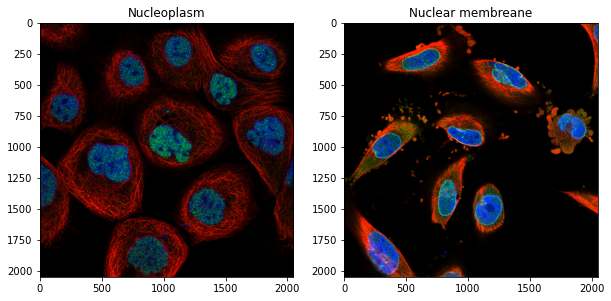

In [10]:
fig, ax = plt.subplots(1,2, figsize=(10,10))
ax[0].imshow(skimage.io.imread('images/'+high_ratio[0]))
ax[1].imshow(skimage.io.imread('images/'+low_ratio[0]))
ax[0].set_title('Nucleoplasm');
ax[1].set_title('Nuclear membreane');

Our analysis allows us indeed to automatically find which proteins are enriched on the membrane!

## Import image

First we use ```skimage.io.imread``` to import the images. One can use the function to import from disk or from a server:

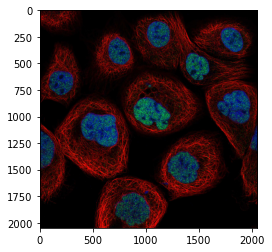

In [12]:
image = skimage.io.imread('https://github.com/guiwitz/PyImageCourse_beginner/raw/cellatlas/images/24138_196_F7_2.tif')
plt.imshow(image);

## Filter the image

To obtain a smoother segmentation, we filter the nuclei images with a median filter:

In [13]:
im_filtered = skimage.filters.median(image[:,:,2], skimage.morphology.disk(5))

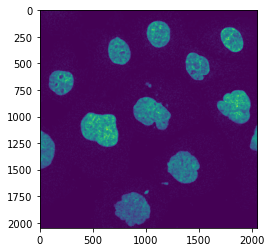

In [14]:
plt.imshow(im_filtered);

## Automated threshold

We now isolate the nuclei by setting an intensity threshold automatically using the Otsu method:

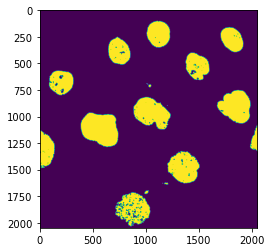

In [15]:
th = skimage.filters.threshold_otsu(im_filtered)
nucl_th = im_filtered > th
plt.imshow(nucl_th);

## Clean-up with morphological operations

We still have some debris and holes in the nuclei. We can use morphological operation to fix these problems:

In [16]:
nucl_close = skimage.morphology.binary_closing(nucl_th, selem=skimage.morphology.disk(5))
nucl_fill = ndi.binary_fill_holes(nucl_close, skimage.morphology.disk(5))

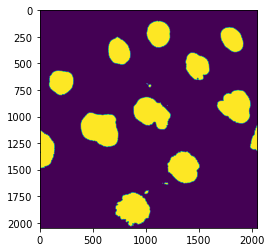

In [17]:
plt.imshow(nucl_fill);

## Compute a band around the nuclei

Now we need to measure intensity in two different non-overlapping regions: inside the nuclei and on their border. To obtain the region **inside** the nuclei we simply erode their borders. Once we have such *smaller* nuclei, we can just subtract them from the original *larger* ones and obtain a band corresponding to the membrane. The size of this border depends on how much we eroded in the first place: 

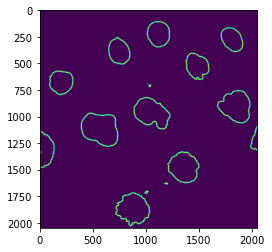

In [18]:
eroded = skimage.morphology.binary_erosion(nucl_fill, selem=skimage.morphology.disk(10))
edge = np.logical_and(nucl_fill, np.logical_not(eroded))

plt.imshow(edge);

## Label nuclei and band and measure properties

Now that we have pairs of binary masks, for nucleoplasm and nuclear membrane, we can label *connected* regions to measure them. We actually first label the *original* segmentation and only *then* mask those labels with the two binary segmentations in order to have the *same* labels for both, so that we can compare them. Once we have labelled regions we can measure for each element (particle in Fiji) multiple properties such as the ```area``` but also e.g. ```mean_intensity``` in the other channel:

In [19]:
im_lab = skimage.morphology.label(nucl_fill)
measure_eroded = skimage.measure.regionprops_table(im_lab * eroded, image[:,:,1], properties=('label', 'mean_intensity', 'area'))
measure_edge = skimage.measure.regionprops_table(im_lab * edge, image[:,:,1], properties=('label', 'mean_intensity', 'area'))

## Post-processing: stats 

Finally, we want to measure the ratio of the intensity in the two segmentations. We could do it using Pandas dataframes but since this course doesn't focus on that package we do it manually. We first create a dictionary with labels as keys and mean intensity on the membrane as values. We then use this dictionary as a lookup table to match objects in both segmentations and calculate the intensity ratio:

In [20]:
edge_dict = {}
for i in range(len(measure_edge['label'])):
    if measure_edge['area'][i] > 100:
        edge_dict[measure_edge['label'][i]] = measure_edge['mean_intensity'][i]
image_ratio = []
for i in range(len(measure_eroded['label'])):
    temp_ratio = measure_eroded['mean_intensity'][i] / edge_dict[measure_eroded['label'][i]]
    image_ratio.append(temp_ratio)
mean_val  = np.mean(image_ratio)
mean_val

1.633106405481683

or

In [21]:
import pandas as pd
measure_eroded_df = pd.DataFrame(measure_eroded)
measure_edge_df = pd.DataFrame(measure_edge)

In [22]:
merged = pd.merge(measure_eroded_df, measure_edge_df, on='label', how='inner')
merged['ratio'] = merged['mean_intensity_x']/merged['mean_intensity_y']

In [23]:
mean_val = merged.mean()['ratio']
mean_val

1.633106405481683